In [11]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import train_test_split


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

training_dataset_path = "/kaggle/input/museum/Training"
testing_dataset_path = "/kaggle/input/museum/Museum_Validation"
classes = ["museum-indoor", "museum-outdoor"]
img_size = (128, 128)  

def load_and_preprocess_images(dataset_path, classes, img_size, normalize=True):
    images, labels = [], []

    for class_idx, class_label in enumerate(classes):
        class_path = os.path.join(dataset_path, class_label)
        image_files = os.listdir(class_path)

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            try:
                img = Image.open(image_path).convert("RGB") 
                img = img.resize(img_size)  
                img_array = np.array(img, dtype=np.float32)

                if normalize:
                    img_array /= 255.0 

                images.append(img_array)
                labels.append(class_idx)

            except Exception as e:
                print(f"Skipping {image_file}: {e}")

    return np.array(images), np.array(labels)

train_images, train_labels = load_and_preprocess_images(training_dataset_path, classes, img_size)
test_images, test_labels = load_and_preprocess_images(testing_dataset_path, classes, img_size)
print(f"Training Set: {train_images.shape}")
print(f"Testing Set: {test_images.shape}")

Training Set: (10000, 128, 128, 3)
Testing Set: (200, 128, 128, 3)


In [12]:
# train_images, test_images, train_labels, test_labels = train_test_split(
#     images, labels, test_size=0.2, random_state=42, stratify=labels
# )





train_features = train_images.reshape(train_images.shape[0], -1).astype(np.float32)
test_features = test_images.reshape(test_images.shape[0], -1).astype(np.float32)
print(f"Training Features: {train_features.shape}")
print(f"Testing Features: {test_features.shape}")


scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
print("Scaling complete.")

pca = PCA(n_components=1000)  
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)
print("PCA complete.")
# train_features_pca = train_features_scaled
# test_features_pca = test_features_scaled
# Check new dimensions
print(f"New Training Set Shape: {train_features_pca.shape}")
print(f"New Testing Set Shape: {test_features_pca.shape}")

Training Features: (10000, 49152)
Testing Features: (200, 49152)
Scaling complete.
PCA complete.
New Training Set Shape: (10000, 1000)
New Testing Set Shape: (200, 1000)


In [13]:
def displayResults_DT(grid_search,test_features):
    results = grid_search.cv_results_

    comparison_df = pd.DataFrame({
        "max_depth": results["param_max_depth"],
        "min_samples_split": results["param_min_samples_split"],
        "criterion": results["param_criterion"],
        "mean_test_score": results["mean_test_score"],
        "std_test_score": results["std_test_score"],
        "mean_fit_time": results["mean_fit_time"]
    })
    
    
    best_preds = grid_search.best_estimator_.predict(test_features)

    comparison_df["Accuracy"] = results["mean_test_score"]
    comparison_df["Precision"] = precision_score(test_labels, best_preds, average='weighted')
    comparison_df["Recall"] = recall_score(test_labels, best_preds, average='weighted')
    comparison_df["F1-Score"] = f1_score(test_labels, best_preds, average='weighted')

    print("\nHyperparameter Comparison Results:\n")
    print(comparison_df)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(test_labels, best_preds), annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Best Model")
    plt.show()



Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Best Model Test Accuracy: 0.7900

Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80       100
           1       0.81      0.76      0.78       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200


Hyperparameter Comparison Results:

  max_depth min_samples_split criterion  mean_test_score  std_test_score  \
0         5                 2      gini         0.783600        0.002623   
1         5                 5      gini         0.783600        0.002623   
2        10                 2      gini         0.763000        0.003316   
3        10                 5      gini         0.765499        0.004255   
4         5                 2   entropy         0.780999        0.007023   
5         5               

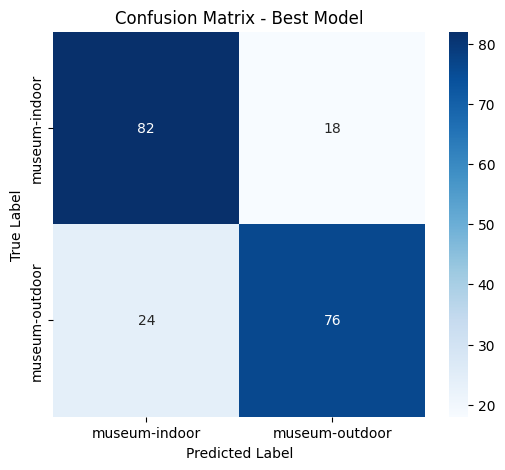

In [14]:




param_grid = {
    "max_depth": [5, 10],  
    "min_samples_split": [2, 5],  
    # "min_samples_leaf": [],
    "criterion": ["gini", "entropy"]  
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, n_jobs=1)
grid_search.fit(train_features_pca, train_labels)

best_clf = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

best_preds = best_clf.predict(test_features_pca)
print(f"Best Model Test Accuracy: {accuracy_score(test_labels, best_preds):.4f}")
print("\nBest Model Classification Report:\n", classification_report(test_labels, best_preds))


displayResults_DT(grid_search,test_features_pca)


In [15]:
def displayResults_RF(grid_search,test_features):
    results = grid_search.cv_results_

    comparison_df = pd.DataFrame({
        "n_estimators": results["param_n_estimators"],
        "max_depth": results["param_max_depth"],
        "min_samples_split": results["param_min_samples_split"],
        "mean_test_score": results["mean_test_score"],
        "std_test_score": results["std_test_score"],
        "mean_fit_time": results["mean_fit_time"]
    })
    
    # Evaluate best model only once
    best_rf_preds = grid_search.best_estimator_.predict(test_features)

    comparison_df["Accuracy"] = accuracy_score(test_labels, best_rf_preds)
    comparison_df["Precision"] = precision_score(test_labels, best_rf_preds, average='weighted')
    comparison_df["Recall"] = recall_score(test_labels, best_rf_preds, average='weighted')
    comparison_df["F1-Score"] = f1_score(test_labels, best_rf_preds, average='weighted')

    print("\nHyperparameter Comparison Results:\n")
    print(comparison_df)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(test_labels, best_rf_preds), annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Best Model")
    plt.show()

Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Model Test Accuracy: 0.8750

Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       100
           1       0.89      0.86      0.87       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200


Hyperparameter Comparison Results:

  n_estimators max_depth min_samples_split  mean_test_score  std_test_score  \
0           50        10                 5           0.8835          0.0059   
1          100        10                 5           0.8854          0.0050   
2           50        10                10           0.8864          0.0062   
3          100        10                10           0.8868          0.0054   
4           50        20 

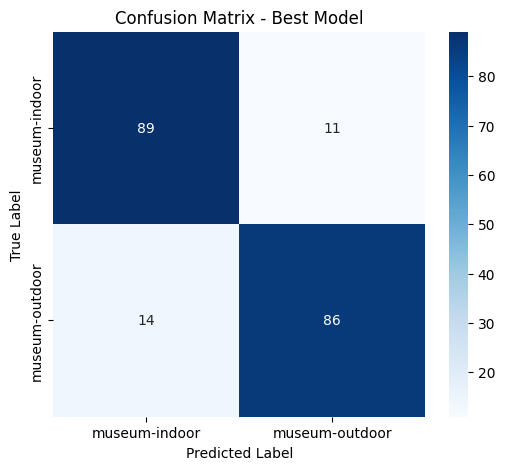

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": [50, 100],  # Number of trees
    "max_depth": [10, 20],  # Maximum depth of trees
    "min_samples_split": [5, 10]  # Minimum samples required to split a node
}

# Perform Grid Search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),  # Use all CPU cores
    param_grid, 
    cv=2, 
    n_jobs=-1,  
    verbose=1  
)

grid_search.fit(train_features, train_labels)


best_rf_clf = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Predict with best model
best_rf_preds = best_rf_clf.predict(test_features)


best_accuracy = accuracy_score(test_labels, best_rf_preds)
print(f"Best Model Test Accuracy: {best_accuracy:.4f}")
print("\nBest Model Classification Report:\n", classification_report(test_labels, best_rf_preds))

displayResults_RF(grid_search,test_features)

In [18]:
def displayResults_xgb(grid_search,test_features_pca):
    results = grid_search.cv_results_

    comparison_df = pd.DataFrame({
        "n_estimators": results["param_n_estimators"],
        "max_depth": results["param_max_depth"],
        "learning_rate": results["param_learning_rate"],
        "mean_test_score": results["mean_test_score"],
        "std_test_score": results["std_test_score"],
        "mean_fit_time": results["mean_fit_time"]
    })
    
    # Evaluate best model only once
    best_xgb_preds = grid_search.best_estimator_.predict(test_features_pca)

    comparison_df["Accuracy"] = accuracy_score(test_labels, best_xgb_preds)
    comparison_df["Precision"] = precision_score(test_labels, best_xgb_preds, average='weighted')
    comparison_df["Recall"] = recall_score(test_labels, best_xgb_preds, average='weighted')
    comparison_df["F1-Score"] = f1_score(test_labels, best_xgb_preds, average='weighted')

    print("\nHyperparameter Comparison Results:\n")
    print(comparison_df)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(test_labels, best_xgb_preds), annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Best Model")
    plt.show()

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Model Test Accuracy: 0.8800

Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       100
           1       0.92      0.83      0.87       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200


Hyperparameter Comparison Results:

   n_estimators max_depth learning_rate  mean_test_score  std_test_score  \
0            50         3          0.01           0.7766          0.0014   
1           100         3          0.01           0.7933          0.0033   
2           200         3          0.01           0.8185          0.0015   
3           300         3          0.01           0.8352          0.0002   
4            50         5          0.01           0.8165          0.0005   
5           100         5   

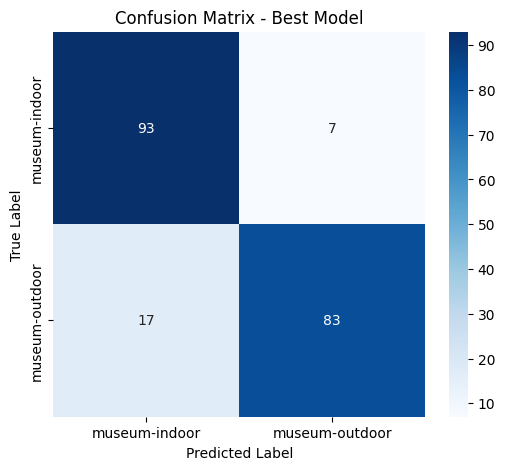

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define XGBoost hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200,300], 
    "max_depth": [3, 5, 7], 
    "learning_rate": [0.01, 0.1, 0.2],  
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Perform Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(xgb_clf, param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(train_features_pca, train_labels)

# Best model from GridSearch
best_xgb = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Evaluate best model
best_preds = best_xgb.predict(test_features_pca)

# Print performance metrics
print(f"Best Model Test Accuracy: {accuracy_score(test_labels, best_preds):.4f}")
print("\nBest Model Classification Report:\n", classification_report(test_labels, best_preds))

displayResults_xgb(grid_search,test_features_pca)

Original Training Data: (10000, 1000)
Testing Data (Unchanged): (200, 1000)
Initially Labeled Data: (2000, 1000)
Initially Unlabeled Data: (8000, 1000)

Iteration 1...
Adding 6059 high-confidence pseudo-labeled samples.

Iteration 2...
Adding 22 high-confidence pseudo-labeled samples.

Iteration 3...
No high-confidence samples found. Stopping early.

Final Test Accuracy: 0.7350

Final Model Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       100
           1       0.75      0.70      0.73       100

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200



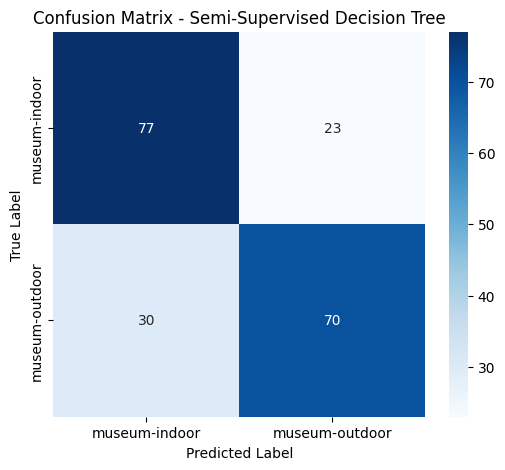

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print(f"Original Training Data: {train_features_pca.shape}")
print(f"Testing Data (Unchanged): {test_features_pca.shape}")

# Split labeled and unlabeled data
labeled_features, unlabeled_features, labeled_labels, unlabeled_true_labels = train_test_split(
    train_features_pca, train_labels, test_size=0.80, random_state=42, stratify=train_labels
)

print(f"Initially Labeled Data: {labeled_features.shape}")
print(f"Initially Unlabeled Data: {unlabeled_features.shape}")

# Number of iterations for semi-supervised learning
num_iterations = 10  

for iteration in range(num_iterations):
    print(f"\nIteration {iteration + 1}...")

    # Initialize Decision Tree model
    model = DecisionTreeClassifier(random_state=42,criterion="gini", max_depth= 5, min_samples_split= 2)
    model.fit(labeled_features, labeled_labels)

    # Get predicted probabilities for the unlabeled data
    predicted_probs = model.predict_proba(unlabeled_features)
    predicted_labels = np.argmax(predicted_probs, axis=1)  
    max_probs = np.max(predicted_probs, axis=1)  

    # Select high-confidence samples based on the probabilities
    high_confidence_indices = np.where((max_probs >= 0.85) | (max_probs <= 0.15))[0]

    if len(high_confidence_indices) == 0:
        print("No high-confidence samples found. Stopping early.")
        break

    print(f"Adding {len(high_confidence_indices)} high-confidence pseudo-labeled samples.")

    # Add high-confidence pseudo-labeled data to the labeled set
    labeled_features = np.vstack([labeled_features, unlabeled_features[high_confidence_indices]])
    labeled_labels = np.hstack([labeled_labels, predicted_labels[high_confidence_indices]])

    # Remove high-confidence samples from the unlabeled set
    mask = np.ones(len(unlabeled_features), dtype=bool)
    mask[high_confidence_indices] = False
    unlabeled_features = unlabeled_features[mask]

    if len(unlabeled_features) == 0:
        print("All samples labeled. Stopping.")
        break

# Train the final model on the labeled data
final_model = DecisionTreeClassifier(random_state=42,criterion="gini", max_depth= 5, min_samples_split= 2)
final_model.fit(labeled_features, labeled_labels)

# Evaluate the model on the test data
final_preds = final_model.predict(test_features_pca)

# Print the final accuracy and classification report
print(f"\nFinal Test Accuracy: {accuracy_score(test_labels, final_preds):.4f}")
print("\nFinal Model Classification Report:\n", classification_report(test_labels, final_preds))

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(test_labels, final_preds), annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Semi-Supervised Decision Tree")
plt.show()